# 16.6. Neural Collaborative Filtering for Personalized Ranking

https://d2l.ai/chapter_recommender-systems/neumf.html

In [1]:
from itertools import chain, filterfalse
from collections import defaultdict

from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from surprise import Dataset
from sklearn.model_selection import train_test_split
from scipy import sparse

## Dataset/DataLoader

In [2]:
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
n_users = trainset.n_users
n_items = trainset.n_items

trainset = [el for el in trainset.all_ratings()]
trainset = list(trainset)
trainset, testset = train_test_split(trainset, test_size=0.2)

n_users, n_items

(943, 1682)

In [3]:
a = set([1, 2, 3])
a = list(a)
np.random.choice(a)

3

In [4]:
class MLDataset(Dataset):
    def __init__(self, data, n_users, n_items):
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.IuS = defaultdict(set)
        self.UiS = defaultdict(set)
        self.all_items = set(range(n_items))
        
        for user, item, _ in self.data:
            self.IuS[item].add(user)
            self.UiS[user].add(item)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """
        (u, i, j) \in D_s
        """
        user = self.data[index][0]
        item_i = self.data[index][1]
        item_j = list(self.all_items - self.UiS[user])
        item_j = np.random.choice(item_j)
        
        return (torch.LongTensor([user]),
                torch.LongTensor([item_i]),
                torch.LongTensor([item_j]),)

In [5]:
train_dl = DataLoader(
    MLDataset(trainset, n_users, n_items), shuffle=True, batch_size=1024, pin_memory=True
)
test_dl = DataLoader(
    MLDataset(testset, n_users, n_items), shuffle=False, batch_size=1024, pin_memory=True
)

In [13]:
from collections import Counter

a = np.random.randint(10, size=100)
a

array([0, 8, 0, 7, 1, 1, 5, 3, 7, 9, 2, 1, 0, 9, 9, 2, 9, 2, 1, 4, 1, 5,
       6, 6, 3, 6, 1, 8, 0, 5, 3, 2, 9, 5, 2, 3, 8, 4, 9, 8, 8, 8, 4, 7,
       2, 1, 6, 8, 0, 3, 7, 0, 4, 5, 9, 3, 3, 0, 9, 2, 6, 9, 7, 3, 6, 2,
       3, 7, 8, 9, 3, 0, 4, 0, 7, 0, 7, 2, 3, 0, 1, 4, 9, 9, 8, 6, 3, 6,
       3, 6, 9, 2, 2, 4, 5, 1, 8, 0, 9, 0])

In [14]:
counter = Counter(a)

In [15]:
counter.most_common(5)

[(9, 14), (0, 13), (3, 13), (2, 11), (8, 10)]

In [17]:
counter = Counter([len(train_dl.dataset.UiS[user])
                   for user in range(train_dl.dataset.n_users)])

In [18]:
counter.most_common(5)

[(21, 29), (16, 26), (19, 25), (18, 22), (22, 21)]

<AxesSubplot:>

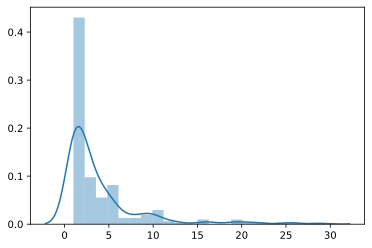

In [22]:
_, freq = tuple(zip(*counter.items()))

sns.distplot(freq)

## Model

In [6]:
class NeuMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, mlp_hiddens):
        super().__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        mlp_layers = [num_factors * 2] + mlp_hiddens + [num_factors]
        mlp_layers = [[nn.Linear(inp, out), nn.ReLU()]
                  for inp, out in zip(mlp_layers, mlp_layers[1:])]
        self.mlp = nn.Sequential(*list(chain.from_iterable(mlp_layers)))
        
    def forward(self, user_id, item_id):
        user_id = user_id.view((-1,))
        item_id = item_id.view((-1,))
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(torch.cat([p_mlp, q_mlp], axis=-1))
        y_ui = torch.cat([gmf, mlp], dim=-1)
        y_ui = torch.sum(y_ui, axis=-1, keepdim=True)
        return y_ui

## Loss

In [7]:
class BPROptLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_ui, y_uj):
        """
        y_logits: N x 1
        neg_items: N x n_items
        """
        return -torch.sum(torch.log(torch.sigmoid(y_ui - y_uj)))

## Evaluator

In [23]:
# incomplete

## Training

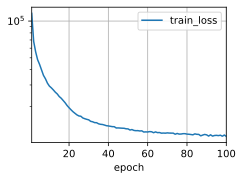

In [8]:
device = torch.device('cuda')
epochs = 100

net = NeuMF(10, n_users, n_items, [10, 10])
net.to(device)
criterion = BPROptLoss()
optimizer = torch.optim.Adam(
    net.parameters(), lr=0.002, weight_decay=1e-3)

animator = d2l.Animator(
    xlabel='epoch', xlim=[1, epochs],
    yscale='log',
    legend=['train_loss']
)

for epoch in range(1, epochs + 1):

    net.train()
    running_loss = 0.0
    for user_ids, item_is, item_js in train_dl:
        user_ids = user_ids.to(device)
        item_is = item_is.to(device)
        item_js = item_js.to(device)

        optimizer.zero_grad()
        
        y_is = net(user_ids, item_is)        
        y_js = net(user_ids, item_js)
        loss = criterion(y_is, y_js)
            
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    animator.add(epoch, running_loss)

In [9]:
I, J, V = tuple(zip(*trainset))
Y_test = sparse.coo_matrix((V, (I, J)), shape=(n_users, n_items)).tocsr()
Y_test = torch.from_numpy(Y_test.toarray()).float()
Y_test = torch.sign(Y_test)
Y_test.shape

torch.Size([943, 1682])

In [10]:
net.eval()
net.cpu()

Y_prob = torch.zeros_like(Y_test)

for user in range(n_users):
    y_logit = net(
        torch.LongTensor([user]).expand((n_items, 1)),
        torch.LongTensor(range(n_items)))
    Y_prob[user, :] = torch.sigmoid(y_logit.squeeze())

In [11]:
Y_prob

tensor([[0.9999, 1.0000, 0.9877,  ..., 0.8411, 0.7427, 0.8248],
        [0.9997, 1.0000, 0.9988,  ..., 0.9976, 0.9990, 0.9987],
        [0.9945, 0.9994, 0.9999,  ..., 0.7742, 0.7571, 0.7451],
        ...,
        [0.9998, 1.0000, 0.9543,  ..., 0.6205, 0.6357, 0.6421],
        [0.9999, 1.0000, 0.9974,  ..., 0.8808, 0.9755, 0.9558],
        [0.9999, 1.0000, 0.9875,  ..., 0.7585, 0.7250, 0.6760]],
       grad_fn=<CopySlices>)

In [12]:
Y_test

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])